# Modelo de Classificação para Startups
Este notebook apresenta todo o fluxo de pré-processamento, engenharia de atributos, seleção de variáveis, modelagem e avaliação de classificadores para prever a variável de interesse `labels`. O pipeline utiliza técnicas avançadas de Machine Learning, incluindo `StackingClassifier` com RandomizedSearchCV para ajuste de hiperparâmetros.

## 1) Importação das Bibliotecas

In [ ]:
# Importação de bibliotecas essenciais para manipulação de dados
import pandas as pd          # Análise e manipulação de dados em tabelas (DataFrames)
import numpy as np           # Cálculos numéricos e matrizes
import matplotlib.pyplot as plt  # Visualização de gráficos
import seaborn as sns        # Visualização estatística com gráficos mais elaborados

# Ferramentas de machine learning do scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV  # divisão de dados e validação cruzada
from sklearn.preprocessing import StandardScaler, PolynomialFeatures  # normalização e criação de features polinomiais
from sklearn.compose import ColumnTransformer   # aplicar transformações em colunas específicas
from sklearn.pipeline import Pipeline           # encadear etapas em um fluxo de processamento
from sklearn.impute import SimpleImputer        # tratamento de valores ausentes (missing values)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # métricas de avaliação

# Modelos de classificação
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# Seleção de features com base na importância
from sklearn.feature_selection import SelectFromModel

# Supressão de avisos para manter o notebook limpo
import warnings
warnings.filterwarnings("ignore")

# Definição de semente aleatória para reprodutibilidade dos resultados
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



## 2) Leitura dos Dados

In [ ]:
# Leitura dos conjuntos de dados
train = pd.read_csv('train.csv')           # Dados de treino
test = pd.read_csv('test.csv')             # Dados de teste
submission = pd.read_csv('sample_submission.csv')  # Arquivo de submissão de exemplo

# Exibe informações básicas sobre os dados
print("Shape do treino:", train.shape)     # Dimensão (linhas x colunas) do treino
print("Shape do teste:", test.shape)       # Dimensão do teste
print("Distribuição dos labels:\n", train['labels'].value_counts())  # Frequência de cada classe alvo

Shape do treino: (646, 33)
Shape do teste: (277, 32)
Distribuição dos labels:
 labels
1    418
0    228
Name: count, dtype: int64


## 3) Limpeza e Tratamento de Nulos

In [ ]:

# Tratamento de valores ausentes (nulos) em treino e teste
for df in (train, test):
    df['funding_total_usd'] = df['funding_total_usd'].fillna(0)   # Substitui nulos por 0
    df['avg_participants'] = df['avg_participants'].fillna(0)
    df['funding_rounds'] = df['funding_rounds'].fillna(0)
    df['milestones'] = df['milestones'].fillna(0)
    df['relationships'] = df['relationships'].fillna(0)

    # Garante que as colunas de localização existam e estejam sem nulos
    for col in ['is_CA','is_NY','is_MA','is_TX','is_otherstate']:
        if col not in df.columns:   # Se a coluna não existir, cria com valor 0
            df[col] = 0
        else:                       # Se existir, preenche nulos com 0
            df[col] = df[col].fillna(0)


## 4) Engenharia de Features

In [ ]:
# Função para criar novas variáveis (engenharia de features)
def create_features(df):
    df = df.copy()

    # Transformações matemáticas e logarítmicas
    df['funding_total_usd_log'] = np.log1p(df['funding_total_usd'])   # Escala log do funding
    df['sqrt_funding'] = np.sqrt(df['funding_total_usd'])             # Raiz quadrada do funding
    df['log_participants'] = np.log1p(df['avg_participants'])         # Escala log dos participantes

    # Durações de eventos
    df['funding_duration'] = df['age_last_funding_year'] - df['age_first_funding_year']
    df['milestone_duration'] = df['age_last_milestone_year'] - df['age_first_milestone_year']

    # Razões e médias
    df['avg_funding_per_round'] = df['funding_total_usd'] / (df['funding_rounds'] + 1)
    df['relationships_per_milestone'] = df['relationships'] / (df['milestones'] + 1)
    df['funding_per_participant'] = df['funding_total_usd'] / (df['avg_participants'] + 1)

    # Indicadores binários
    df['has_funding'] = (df['funding_total_usd'] > 0).astype(int)
    df['has_milestone'] = (df['milestones'] > 0).astype(int)
    df['has_relationships'] = (df['relationships'] > 0).astype(int)

    # Interações entre variáveis de localização e funding
    df['ca_funding_inter'] = df['is_CA'] * df['funding_total_usd_log']
    df['ny_funding_inter'] = df['is_NY'] * df['funding_total_usd_log']

    # Razão entre duração de funding e milestones
    df['duration_ratio'] = np.where(df['milestone_duration'] != 0,
                                    df['funding_duration'] / (df['milestone_duration'] + 1e-6),
                                    0.0)

    return df

# Aplica a criação de features em treino e teste
train = create_features(train)
test = create_features(test)


## 5) Codificação de Variáveis Categóricas

In [ ]:
# Define o número de categorias mais frequentes que serão mantidas
TOP_K = 30
top_cats = train['category_code'].value_counts().nlargest(TOP_K).index.tolist()

# Substitui categorias pouco frequentes por "__other__"
train['category_top'] = train['category_code'].where(train['category_code'].isin(top_cats), other='__other__')
test['category_top'] = test['category_code'].where(test['category_code'].isin(top_cats), other='__other__')

# Função de target encoding (codifica categorias pela média do target em K-folds)
def target_encode_oof(train_df, target, cat_col, n_splits=5, random_state=RANDOM_STATE):
    train_idx = train_df.index
    oof = pd.Series(index=train_idx, dtype=float)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    y = target

    # Para cada divisão do K-fold, calcula a média do target por categoria
    for tr_idx, val_idx in skf.split(train_df, y):
        tr_cat = train_df.iloc[tr_idx][cat_col]
        tr_y = y.iloc[tr_idx]
        means = tr_y.groupby(tr_cat).mean()
        oof.iloc[val_idx] = train_df.iloc[val_idx][cat_col].map(means).fillna(y.mean())

    # Média geral por categoria em todo o dataset
    whole_means = y.groupby(train_df[cat_col]).mean().to_dict()
    return oof, whole_means, y.mean()

# Aplica target encoding no treino (com OOF) e no teste (mapa aprendido no treino)
oof_te, te_map, global_mean = target_encode_oof(train, train['labels'], 'category_top')
train['category_te'] = oof_te
test['category_te'] = test['category_top'].map(te_map).fillna(global_mean)

# Cria codificação por frequência da categoria
freq_map = train['category_top'].value_counts(normalize=True).to_dict()
train['category_freq'] = train['category_top'].map(freq_map).fillna(0.0)
test['category_freq'] = test['category_top'].map(freq_map).fillna(0.0)



## 6) Tratamento de Outliers

In [ ]:
# Lista das colunas numéricas que serão tratadas para reduzir o impacto de outliers
numeric_for_clip = ['funding_total_usd','avg_participants','avg_funding_per_round',
                    'funding_per_participant','sqrt_funding','funding_total_usd_log']

# Loop sobre cada coluna numérica da lista
for col in numeric_for_clip:
    # Calcula o percentil de 1% da coluna (limite inferior)
    low = train[col].quantile(0.01)
    
    # Calcula o percentil de 99% da coluna (limite superior)
    high = train[col].quantile(0.99)
    
    # Aplica o clipping: valores abaixo de 'low' se tornam 'low', valores acima de 'high' se tornam 'high'
    train[col] = train[col].clip(low, high)



## 7) Preparação das Variáveis de Entrada (X) e Saída (y)

In [ ]:
# Preparação de X e y
# Lista das variáveis numéricas e categóricas já transformadas (features) que serão usadas como entrada do modelo
num_features = [
    'age_first_funding_year','age_last_funding_year',      # Idade da empresa no primeiro e último financiamento
    'age_first_milestone_year','age_last_milestone_year',  # Idade da empresa no primeiro e último marco
    'relationships','funding_rounds','funding_total_usd_log',  # Quantidade de relacionamentos, rodadas de financiamento e log do total financiado
    'milestones','avg_participants',                       # Número de marcos alcançados e média de participantes
    'funding_duration','milestone_duration',               # Duração total de financiamento e duração até marcos
    'avg_funding_per_round','relationships_per_milestone','funding_per_participant',  # Médias calculadas por rodada/marco/participante
    'sqrt_funding','log_participants','duration_ratio',    # Transformações de variáveis e relação entre durações
    'ca_funding_inter','ny_funding_inter',                # Interações geográficas com financiamento (ex.: CA, NY)
    'has_funding','has_milestone','has_relationships',    # Flags indicando presença de certas informações
    'is_CA','is_NY','is_MA','is_TX','is_otherstate'       # Variáveis dummy de estados
]

# Cria a matriz de features para o conjunto de treino
# Inclui as variáveis numéricas, codificações de categoria e frequência
X = train[num_features + ['category_te','category_freq']]

# Define a variável alvo (labels) para o modelo
y = train['labels']

# Cria a matriz de features para o conjunto de teste
# Mantém consistência com o treino, incluindo as mesmas colunas
X_test = test[num_features + ['category_te','category_freq']]


## 8) Pré-processamento e Pipeline de Modelagem

In [ ]:



# Preprocessamento e pipeline

# Pipeline para pré-processamento das variáveis numéricas
num_pipeline = Pipeline([
    # Substitui valores ausentes pela mediana da coluna
    ('imputer', SimpleImputer(strategy='median')),
    
    # Cria features polinomiais de grau 2, considerando apenas interações entre variáveis
    # Não inclui o termo de bias (coluna de 1s)
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    
    # Padroniza as features (média=0, desvio padrão=1)
    ('scaler', StandardScaler())
])

# Aplica o pipeline numérico a todas as colunas de X
# 'remainder=drop' descarta colunas não numéricas
preprocessor = ColumnTransformer([('num', num_pipeline, X.columns.tolist())], remainder='drop')

# Seleção de features baseada na importância de um modelo (Random Forest)
# Mantém apenas features acima do limiar da mediana
selector = SelectFromModel(
    RandomForestClassifier(
        n_estimators=800,           # Número de árvores
        class_weight='balanced',    # Ajusta pesos para classes desbalanceadas
        random_state=RANDOM_STATE
    ),
    threshold='median'              # Seleciona features com importância acima da mediana
)

# Três estimadores base para o stacking ensemble
est1 = HistGradientBoostingClassifier(
    max_iter=1000,
    learning_rate=0.02,
    max_depth=8,
    random_state=RANDOM_STATE
)
est2 = HistGradientBoostingClassifier(
    max_iter=700,
    learning_rate=0.03,
    max_depth=6,
    random_state=RANDOM_STATE+1
)
est3 = RandomForestClassifier(
    n_estimators=1200,
    max_depth=None,
    max_features='sqrt',
    class_weight='balanced',
    random_state=RANDOM_STATE+2
)

# Estimador final do stacking (Logistic Regression)
final_est = LogisticRegression(
    max_iter=5000,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

# Stacking Classifier: combina os três estimadores base, usando a regressão logística para a predição final
stack = StackingClassifier(
    estimators=[('hgb1', est1), ('hgb2', est2), ('rf', est3)],
    final_estimator=final_est,
    n_jobs=-1,       # Usa todos os núcleos disponíveis
    passthrough=False # Não adiciona as features originais ao final para o estimador final
)

# Pipeline final: combina pré-processamento, seleção de features e modelo ensemble
pipeline = Pipeline([
    ('preproc', preprocessor),  # Pré-processamento
    ('select', selector),       # Seleção de features
    ('stack', stack)            # Modelo final (stacking ensemble)
])


## 9) Divisão Treino/Validação

In [ ]:
# Divide os dados em conjuntos de treino e validação
# X e y são as features e labels do conjunto de treino completo
# test_size=0.2 define que 20% dos dados serão usados para validação
# stratify=y mantém a proporção original das classes nos dois conjuntos
# random_state garante que a divisão seja reproduzível
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

## 10) Ajuste de Hiperparâmetros com RandomizedSearchCV

In [ ]:
# Define o espaço de busca dos hiperparâmetros para o RandomizedSearchCV
# Os parâmetros usam a notação 'nome_do_step__nome_do_modelo__nome_do_parametro'
param_dist = {
    # Hiperparâmetros do primeiro HistGradientBoosting (hgb1) do stack
    "stack__hgb1__max_depth": [4, 6, 8, 10],          # profundidade máxima das árvores
    "stack__hgb1__learning_rate": [0.01, 0.02, 0.05], # taxa de aprendizado
    "stack__hgb1__min_samples_leaf": [10, 20, 30],    # mínimo de amostras por folha
    
    # Hiperparâmetros do segundo HistGradientBoosting (hgb2) do stack
    "stack__hgb2__max_depth": [4, 6, 8],
    "stack__hgb2__learning_rate": [0.01, 0.03, 0.05],
    "stack__hgb2__min_samples_leaf": [10, 20, 30],
    
    # Hiperparâmetros do Random Forest (rf) do stack
    "stack__rf__n_estimators": [500, 800, 1200],      # número de árvores
    "stack__rf__max_depth": [None, 10, 20],          # profundidade máxima
    "stack__rf__max_features": ["sqrt", "log2"],     # número de features consideradas em cada divisão
    
    # Hiperparâmetros do estimador final (Logistic Regression) do stack
    "stack__final_estimator__C": [0.1, 1, 10],       # regularização
    "stack__final_estimator__penalty": ["l2"],       # tipo de penalização
    "stack__final_estimator__solver": ["lbfgs", "saga"], # algoritmo de otimização
}

# Cria o RandomizedSearchCV para buscar os melhores hiperparâmetros
random_search = RandomizedSearchCV(
    pipeline,                  # pipeline que inclui pré-processamento, seleção e stack
    param_distributions=param_dist, # espaço de busca definido acima
    n_iter=25,                 # número de combinações aleatórias testadas
    cv=3,                      # 3-fold cross-validation
    scoring="accuracy",        # métrica usada para avaliar o desempenho
    verbose=2,                 # imprime informações detalhadas do progresso
    random_state=RANDOM_STATE, # garante reproducibilidade
    n_jobs=-1                  # usa todos os núcleos disponíveis
)

# Ajusta o RandomizedSearchCV nos dados de treino
random_search.fit(X_train, y_train)

# Exibe os melhores parâmetros encontrados na busca
print("Melhores parâmetros encontrados:")
print(random_search.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Melhores parâmetros encontrados:
{'stack__rf__n_estimators': 500, 'stack__rf__max_features': 'log2', 'stack__rf__max_depth': 10, 'stack__hgb2__min_samples_leaf': 30, 'stack__hgb2__max_depth': 6, 'stack__hgb2__learning_rate': 0.03, 'stack__hgb1__min_samples_leaf': 10, 'stack__hgb1__max_depth': 10, 'stack__hgb1__learning_rate': 0.02, 'stack__final_estimator__solver': 'saga', 'stack__final_estimator__penalty': 'l2', 'stack__final_estimator__C': 1}


## 11) Avaliação do Modelo

Acurácia após tuning: 0.8077

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.77      0.65      0.71        46
           1       0.82      0.89      0.86        84

    accuracy                           0.81       130
   macro avg       0.80      0.77      0.78       130
weighted avg       0.80      0.81      0.80       130



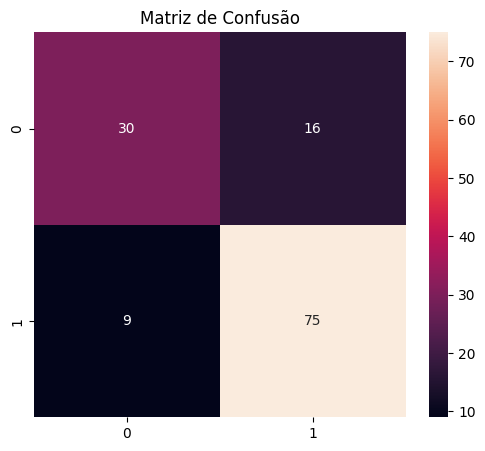

In [ ]:
# Faz a predição nos dados de validação usando o modelo ajustado pelo RandomizedSearchCV
y_val_pred = random_search.predict(X_val)

# Calcula a acurácia do modelo no conjunto de validação
acc_val = accuracy_score(y_val, y_val_pred)
print(f"Acurácia após tuning: {acc_val:.4f}")  # exibe a acurácia com 4 casas decimais

# Exibe métricas detalhadas de classificação, como precisão, recall e f1-score por classe
print("\nRelatório de classificação:")
print(classification_report(y_val, y_val_pred))

# Plota a matriz de confusão para visualizar erros de classificação
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d')  # fmt='d' mostra números inteiros
plt.title("Matriz de Confusão")
plt.show()

## 12) Predição Final e Geração de CSV

In [ ]:
# Recupera o melhor modelo encontrado pelo RandomizedSearchCV
best_model = random_search.best_estimator_

# Faz a predição nos dados de teste usando o modelo ajustado
test_preds = best_model.predict(X_test)

# Cria uma cópia do DataFrame de submission para evitar sobrescrever o original
out = submission.copy()

# Atribui as predições à coluna 'labels' do DataFrame de submission
out['labels'] = test_preds

# Salva o DataFrame atualizado em um arquivo CSV, sem incluir o índice
out.to_csv('submission_final.csv', index=False)

# Mensagem confirmando que o arquivo foi gerado
print("Arquivo submission_final.csv gerado com sucesso!")

Arquivo submission_final.csv gerado com sucesso!
